In [1]:
import random
import matplotlib.pyplot as plt

In [9]:
import requests
import pandas as pd

## process raw data


In [10]:
# Function to get hitters' stats for a team
def get_team_stats(team_id, season=2024, limit=9):
    url = f"https://statsapi.mlb.com/api/v1/stats"
    params = {
        "stats": "season",
        "group": "hitting",
        "season": season,
        "playerPool": "all",
        "gameType": "R",
        "limit": 50,
        "sortStat": "plateAppearances",
        "order": "desc",
        "teamId": team_id
    }
    res = requests.get(url, params=params)
    data = res.json()

    player_stats = []
    for player in data['stats'][0]['splits'][:limit]:
        s = player['stat']
        name = player['player']['fullName']
        PA = int(s.get("plateAppearances", 0))
        H = int(s.get("hits", 0))
        doubles = int(s.get("doubles", 0))
        triples = int(s.get("triples", 0))
        HR = int(s.get("homeRuns", 0))
        BB = int(s.get("baseOnBalls", 0))

        singles = H - doubles - triples - HR
        P_single = singles / PA if PA else 0
        P_double = doubles / PA if PA else 0
        P_triple = triples / PA if PA else 0
        P_HR = HR / PA if PA else 0
        P_BB = BB / PA if PA else 0
        P_out = 1 - (P_single + P_double + P_triple + P_HR + P_BB)

        player_stats.append({
            "name": name,
            "probs": [round(P_single, 4), round(P_double, 4), round(P_triple, 4),
                      round(P_HR, 4), round(P_BB, 4), round(P_out, 4)]
        })

    return pd.DataFrame(player_stats)

# Team IDs from MLB API
WHITE_SOX_ID = 145
YANKEES_ID = 147

# Get top 9 batters
white_sox_probs = get_team_stats(WHITE_SOX_ID)
yankees_probs = get_team_stats(YANKEES_ID)

# Display
print("Chicago White Sox Batting Probabilities:\n", white_sox_probs)
print("\nNew York Yankees Batting Probabilities:\n", yankees_probs)


Chicago White Sox Batting Probabilities:
                 name                                             probs
0      Andrew Vaughn  [0.1454, 0.0485, 0.0016, 0.0307, 0.0614, 0.7124]
1  Andrew Benintendi     [0.1322, 0.0383, 0.0, 0.0383, 0.0785, 0.7126]
2       Gavin Sheets     [0.1397, 0.0479, 0.002, 0.02, 0.0858, 0.7046]
3        Nicky Lopez   [0.1798, 0.027, 0.0067, 0.0022, 0.0831, 0.7011]
4    Luis Robert Jr.     [0.1294, 0.0447, 0.0, 0.0329, 0.0659, 0.7271]
5          Korey Lee   [0.132, 0.0355, 0.0025, 0.0305, 0.0431, 0.7563]
6         Lenyn Sosa     [0.1843, 0.0352, 0.0, 0.0217, 0.0325, 0.7263]
7       Eloy Jiménez     [0.1647, 0.0361, 0.0, 0.0201, 0.0723, 0.7068]
8   Dominic Fletcher     [0.1535, 0.0332, 0.0, 0.0041, 0.0456, 0.7635]

New York Yankees Batting Probabilities:
                 name                                             probs
0          Juan Soto  [0.1262, 0.0435, 0.0056, 0.0575, 0.1809, 0.5863]
1        Aaron Judge  [0.1207, 0.0511, 0.0014, 0.0824, 0.1889, 0

## model code


In [12]:

# Define batting outcome names
outcomes = ["single", "double", "triple", "home_run", "walk", "out"]

# Team A and B batters: 9 batters each with outcome probabilities (sum must be 1)
team_A = [list(row['probs']) for _, row in white_sox_probs.iterrows()]
team_B = [list(row['probs']) for _, row in yankees_probs.iterrows()]

# Advance runners logic
def advance_runners(runners, outcome):
    runs = 0
    if outcome == "single":
        if runners[2]: runs += 1
        runners = [True] + runners[:2]
    elif outcome == "double":
        if runners[2]: runs += 1
        if runners[1]: runs += 1
        runners = [False, True, runners[0]]
    elif outcome == "triple":
        runs += sum(runners)
        runners = [False, False, True]
    elif outcome == "home_run":
        runs += sum(runners) + 1
        runners = [False, False, False]
    elif outcome == "walk":
        if all(runners): runs += 1
        if runners[1] and runners[2]: runners[2] = True
        if runners[0] and runners[1]: runners[1] = True
        if runners[0]: runners[0] = True
        runners[0] = True
    return runners, runs

# Simulate a half-inning for a team
def simulate_half_inning(team, batter_index):
    outs = 0
    runs = 0
    runners = [False, False, False]
    while outs < 3:
        batter_probs = team[batter_index % 9]
        outcome = random.choices(outcomes, batter_probs)[0]
        if outcome == "out":
            outs += 1
        else:
            runners, gained = advance_runners(runners, outcome)
            runs += gained
        batter_index += 1
    return runs, batter_index

# Simulate one full game
def simulate_game():
    a_index = b_index = 0
    team_A_score = 0
    team_B_score = 0

    for inning in range(9):
        a_run, a_index = simulate_half_inning(team_A, a_index)
        b_run, b_index = simulate_half_inning(team_B, b_index)
        team_A_score += a_run
        team_B_score += b_run

    return team_A_score, team_B_score

# Run many simulations
def run_simulations(n=10000):
    results = []
    team_A_wins = 0
    team_B_wins = 0
    ties = 0

    for _ in range(n):
        a_score, b_score = simulate_game()
        results.append((a_score, b_score))
        if a_score > b_score:
            team_A_wins += 1
        elif b_score > a_score:
            team_B_wins += 1
        else:
            ties += 1

    return results, team_A_wins, team_B_wins, ties

# Run the simulation
sim_results, wins_A, wins_B, ties = run_simulations(10000)

# Calculate average runs per inning
total_A_runs = sum([a for a, b in sim_results])
total_B_runs = sum([b for a, b in sim_results])
total_innings = len(sim_results) * 9  # 9 innings per game

avg_A_per_inning = total_A_runs / total_innings
avg_B_per_inning = total_B_runs / total_innings



## result


Team A ave runs per inning: 0.233
Team B ave runs per inning: 0.389
Team A win rate: 27.47%
Team B win rate: 59.98%
Tie rate: 12.55%


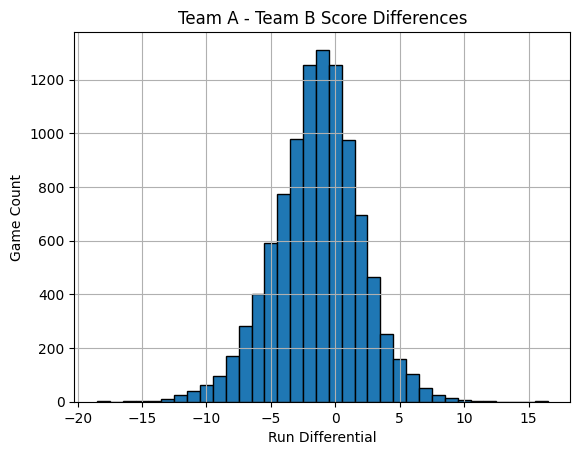

In [13]:
print(f"Team A ave runs per inning: {avg_A_per_inning:.3f}")
print(f"Team B ave runs per inning: {avg_B_per_inning:.3f}")

# Print win stats
print(f"Team A win rate: {wins_A / 10000:.2%}")
print(f"Team B win rate: {wins_B / 10000:.2%}")
print(f"Tie rate: {ties / 10000:.2%}")

# Plot score difference histogram
score_diffs = [a - b for a, b in sim_results]
plt.hist(score_diffs, bins=range(min(score_diffs), max(score_diffs)+1), edgecolor='black', align='left')
plt.title("Team A - Team B Score Differences")
plt.xlabel("Run Differential")
plt.ylabel("Game Count")
plt.grid(True)
plt.show()